In [1]:

import plotly.graph_objects
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas
import datetime
# from pandas.tseries.offsets import *


from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 
import plotly.express as px
import plotly.graph_objects as go

import loguru
import requests

pandas.set_option('display.max_rows', 500)
# import sys
# sys.path.insert(1, '/Users/singularity/Aaron/coding/fintech/OptionsDailyInfoData')

## Time Series
---
利用時間分析結果，建造一個模型  
param = (2, 0, 2)
param_seasonal = (0, 0, 2, 12)

In [2]:
import statsmodels.api as sm
import itertools
import math
import warnings
warnings.filterwarnings("ignore")

In [3]:
filenameTaiexs = f'taiexs-2014-2020.csv'
# filenameTaiexs = f'taiexs-2019.csv'
filepathTaiexs = f'/Users/singularity/Aaron/coding/fintech/{filenameTaiexs}'

dfTaiexs = pandas.read_csv(filepathTaiexs)
dfTaiexs['Date'] = pandas.to_datetime(dfTaiexs['Date'], format='%Y%m%d')


dfTaiexsTS = dfTaiexs.copy()
dfTaiexsTS.index = dfTaiexsTS['Date']
close = dfTaiexsTS['ClosePrice']
taiexDiff = (close-close.shift(1)).dropna()

In [4]:
taiexDiff_MEAN = taiexDiff.mean()
taiexDiff_STD = taiexDiff.std()

In [5]:
def timeSeries(date):
    global taiexDiff
    trainTaiexDiff = taiexDiff[:date]
    param = (2, 0, 2)
    param_seasonal = (0, 0, 2, 12)
    mod = sm.tsa.statespace.SARIMAX(trainTaiexDiff,
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    # Get forecast 2 steps ahead in future
    steps = 2
    pred_uc = results.get_forecast(steps=steps)
    # pred_uc = 0
    # pred_uc.predicted_mean
    return pred_uc.predicted_mean

## /\\ /\\ /\\ /\\ /\\ /\\ /\\ /\\ /\\ /\\ /\\ /\\ /\\ /\\ /\\ /\\

## 以2019/7/29作為例子: Date
Notes: 以下有Date出現都是以此日期作為例子

In [6]:
YEAR = 2019
MONTH = 7
DAY = 29

### 找出Date那天加權股價指數

In [7]:
# filenameTaiexs = f'taiexs-2019.csv'
# filepathTaiexs = f'/Users/singularity/Aaron/coding/fintech/{filenameTaiexs}'

# dfTaiexs = pandas.read_csv(filepathTaiexs)
# dfTaiexs['Date'] = pandas.to_datetime(dfTaiexs['Date'], format='%Y%m%d')

TAIEX_VALUE = 0

TAIEX_VALUE = float(dfTaiexs[dfTaiexs['Date'] == f'{YEAR}-{MONTH:02}-{DAY:02}']['ClosePrice'])
TAIEX_VALUE_BOTTOM = int(TAIEX_VALUE - (TAIEX_VALUE % 50))
TAIEX_VALUE_TOP = TAIEX_VALUE_BOTTOM + 50

print(f'TAIEX_VALUE: {TAIEX_VALUE}')
print(f'TAIEX_VALUE_BOTTOM: {TAIEX_VALUE_BOTTOM}')
print(f'TAIEX_VALUE_TOP: {TAIEX_VALUE_TOP}')

TAIEX_VALUE: 10885.73
TAIEX_VALUE_BOTTOM: 10850
TAIEX_VALUE_TOP: 10900


### 匯入每週結算價表

In [8]:
fileNameSettlementPrice = f'finalSettlementPrice.csv'
filePathSettlementPrice = f'/Users/singularity/Aaron/coding/fintech/{fileNameSettlementPrice}'

dfSettlementPrice = pandas.read_csv(filePathSettlementPrice)
dfSettlementPrice['Date'] = pandas.to_datetime(dfSettlementPrice['Date'], format='%Y/%m/%d')
dfSettlementPrice.sort_values(by='Date', inplace=True)
# dfSettlementPrice["Date"] = dfSettlementPrice["Date"].apply(lambda d:  d-datetime.timedelta(days=2))
dfSettlementPrice["Date"] = dfSettlementPrice.apply(lambda d:  d["Date"]-datetime.timedelta(days=2), axis=1)
dftt = pandas.merge(dfTaiexs, dfSettlementPrice, left_on=["Date"], right_on=["Date"]\
            , suffixes=('_Call','_Put'))[['Date', 'ClosePrice', 'TX/MTX', 'ContractMonthWeek']]

# dftt['Day_of_Week'] = dftt['Date'].dt.day_name()
# dftt

## 前後30天的Taiex

In [9]:
print(f'{YEAR}-{MONTH:02}-{DAY:02}')
dfTaiexsRecent = dfTaiexs[(dfTaiexs['Date'] >= (datetime.datetime(YEAR, MONTH, DAY)-datetime.timedelta(days=30)))& (dfTaiexs['Date'] <= datetime.datetime(YEAR, MONTH, DAY)+datetime.timedelta(days=30))]
dfTaiexsRecent.head()
# dfTaiexs[dfTaiexs['Date'] >= datetime(YEAR, MONTH, DAY-7)]['ClosePrice']


2019-07-29


,Date,OpenPrice,HighestPrice,LowestPrice,ClosePrice
1344,2019-07-01,10821.30,10914.85,10821.30,10895.46
1345,2019-07-02,10878.01,10888.21,10843.64,10865.12
1346,2019-07-03,10793.10,10812.65,10720.66,10743.77
1347,2019-07-04,10755.87,10791.28,10750.90,10775.90
1348,2019-07-05,10785.85,10812.38,10756.67,10785.73


## 前後30天的Taiex的圖表

In [10]:
figTaiexs = go.Figure()

figTaiexs.add_trace(
    go.Scatter(
            x=dfTaiexsRecent["Date"],
            y=dfTaiexsRecent["ClosePrice"],
            name = f"ClosePrice",
            mode='lines'
        ))
figTaiexs.add_trace(go.Scatter(
    x=[datetime.datetime(YEAR, MONTH, DAY)],
    y=[TAIEX_VALUE],
    mode="markers",
    name = f"Taiexs@{YEAR}-{MONTH:02}-{DAY:02}"
    # hovertext=["Text A"]
))
figTaiexs.update_layout(
    title=f"Taiexs@{YEAR}-{MONTH:02}-{DAY:02}",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)
figTaiexs.show()

### 匯入Date那天選擇權交易資料

In [11]:

filename = f'optionsDailyInfo-{YEAR}{MONTH:02}{DAY:02}.csv'
filepath = f'/Users/singularity/Aaron/coding/fintech/OptionsDailyInfoData/{filename}'
df = pandas.read_csv(filepath)
df

,ContractMonthWeek,StrikePrice,CallPut,Open,High,Low,Close,Volume,OpenInterest,BestBid,BestAsk,HistoricalHigh,HistoricalLow,Session
0,201907W5,10100.0,Call,-,-,-,-,0,4,-,-,-,-,Regular
1,201907W5,10100.0,Call,-,-,-,-,0,-,-,-,-,-,AfterHours
2,201907W5,10100.0,Put,0.3,0.3,0.2,0.2,713,1002,0.1,0.3,0.9,0.2,Regular
3,201907W5,10100.0,Put,-,-,-,-,0,-,-,-,-,-,AfterHours
4,201907W5,10200.0,Call,-,-,-,-,0,3,-,-,-,-,Regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,202003,13000.0,Put,-,-,-,-,0,-,-,-,-,-,AfterHours
804,202003,13200.0,Call,-,-,-,-,0,52,-,-,-,-,Regular
805,202003,13200.0,Call,-,-,-,-,0,-,-,-,-,-,AfterHours
806,202003,13200.0,Put,-,-,-,-,0,0,-,-,-,-,Regular


In [12]:
df.astype({
    "ContractMonthWeek": "str"}).dtypes

ContractMonthWeek     object
StrikePrice          float64
CallPut               object
Open                  object
High                  object
Low                   object
Close                 object
Volume                 int64
OpenInterest          object
BestBid               object
BestAsk               object
HistoricalHigh        object
HistoricalLow         object
Session               object
dtype: object

### 篩選出靠近Date那天加權股價指數 $\pm 300$

In [13]:

# df.head(200)
ContractMonthWeek = df["ContractMonthWeek"][0]
# ContractMonthWeek = "201807"

StrikePriceLimite = df["StrikePrice"].apply(lambda d: True if int(d)>=TAIEX_VALUE-300 and int(d) <=TAIEX_VALUE+300 else False)
dfCall = df[(df["CallPut"]=="Call") & (df["Session"]=="Regular") & (df["ContractMonthWeek"]==ContractMonthWeek) & StrikePriceLimite][['ContractMonthWeek', 'StrikePrice','CallPut', 'Close']]
dfPut = df[(df["CallPut"]=="Put") & (df["Session"]=="Regular") & (df["ContractMonthWeek"]==ContractMonthWeek) & StrikePriceLimite][['ContractMonthWeek', 'StrikePrice','CallPut', 'Close']]
# df.loc[StrikePriceLimite]

In [14]:
dfCall.head()

,ContractMonthWeek,StrikePrice,CallPut,Close
20,201907W5,10600.0,Call,285
24,201907W5,10650.0,Call,220
28,201907W5,10700.0,Call,174
32,201907W5,10750.0,Call,126
36,201907W5,10800.0,Call,82


In [15]:
print(f'TAIEX_VALUE: {TAIEX_VALUE}')
print(f'TAIEX_VALUE_BOTTOM: {TAIEX_VALUE_BOTTOM}')
print(f'TAIEX_VALUE_TOP: {TAIEX_VALUE_TOP}\n')
optionsDF = pandas.merge(dfCall, dfPut, left_on=["StrikePrice", 'ContractMonthWeek'], right_on=["StrikePrice",      'ContractMonthWeek']\
            , suffixes=('_Call','_Put'))[['Close_Call', 'CallPut_Call', 'StrikePrice', 'CallPut_Put', 'Close_Put']]
optionsDF

TAIEX_VALUE: 10885.73
TAIEX_VALUE_BOTTOM: 10850
TAIEX_VALUE_TOP: 10900



,Close_Call,CallPut_Call,StrikePrice,CallPut_Put,Close_Put
0,285,Call,10600.0,Put,1.5
1,220,Call,10650.0,Put,2.1
2,174,Call,10700.0,Put,3.6
3,126,Call,10750.0,Put,6.6
4,82,Call,10800.0,Put,14
5,46,Call,10850.0,Put,26.5
6,20.5,Call,10900.0,Put,50
7,7,Call,10950.0,Put,87
8,2.5,Call,11000.0,Put,133
9,0.8,Call,11050.0,Put,182


In [16]:
optionsDF.dtypes
optionsDF.astype({
    "Close_Call": "float64",
    "CallPut_Call": "string",
    "StrikePrice": "int64",
    "CallPut_Put": "string",
    "Close_Put": "float64"}, errors='ignore').dtypes

Close_Call      float64
CallPut_Call     string
StrikePrice       int64
CallPut_Put      string
Close_Put       float64
dtype: object

#### 建立一個選擇權買賣結構，方便後面多種選擇組合使用

In [17]:
class options:
    def __init__(
        self,
        strikePrice,
        optionsDF,
        PutCall,
        BuySell
        ):
        self.strikePrice = strikePrice
        self.optionsDF = optionsDF
        self.PutCall = PutCall
        self.BuySell = BuySell
        # print(f'{self.BuySell}{self.PutCall}@{self.strikePrice}') ##
    def optionsProfit(self, x):
        Exchange_Fee = -1
        y = [0 for _ in range(len(x))]
        
        t = -1 if self.BuySell == "buy" else 1
        s = -50*t
        er = False
        if len(self.optionsDF[self.optionsDF["StrikePrice"] == self.strikePrice]) == 0:
            print(f'{self.BuySell}{self.PutCall}@{self.strikePrice} NOT EXISTS!')
            #  if self.PutCall == "call" else self.strikePrice += 50
            er = True
        if self.PutCall == "call":
            # print(f'@@@@optionsDF\n{self.optionsDF}')
            # print(f'@@@@{self.BuySell}{self.PutCall}@{self.strikePrice}')
            # print(f'@@@@price\n{self.optionsDF[self.optionsDF["StrikePrice"] == self.strikePrice]["Close_Call"]}')
            if er: self.strikePrice -= 50; print(f'Change to {self.BuySell}{self.PutCall}@{self.strikePrice}')
            price = float(self.optionsDF[self.optionsDF["StrikePrice"] == self.strikePrice]["Close_Call"])*t
            self.price = price
            for i in range(len(x)):
                if x[i] <= self.strikePrice:
                    y[i] = price
                else:
                    price += s
                    y[i] = price
        else:
            if er: self.strikePrice += 50; print(f'Change to {self.BuySell}{self.PutCall}@{self.strikePrice}')
            price = float(self.optionsDF[self.optionsDF["StrikePrice"] == self.strikePrice]["Close_Put"])*t
            self.price = price
            for i in range(len(x)-1,-1,-1):
                if x[i] >= self.strikePrice:
                    y[i] = price
                else:
                    price += s
                    y[i] = price
        # return y
        return np.add(y, np.array([Exchange_Fee for _ in range(len(x))]))
    def optionsScatter(self, x):
        return go.Scatter(
            x=x,
            y=self.optionsProfit(x),
            name = f"{self.BuySell}{self.PutCall}@{self.strikePrice}",
            visible = "legendonly",
            mode='lines',
            # line=go.scatter.Line(color='#6B99E5')
            opacity=0.4
        )
    def __repr__(self):
        return(f'{self.BuySell}{self.PutCall}@{self.strikePrice}')


#### 計算某價位都收益函數

In [18]:
def profit(price, x, y):
    i = 0
    while i < len(y):
        if price < x[i]:
            break
        i += 1
    j = i - 1
    if i == 0:
        return y[i]
    elif i == len(y) or y[i]-y[j] == 0:
        return y[j]
    elif y[i]-y[j] > 0:
        return y[j]+(price-x[j])
    else:
        return y[j]-(price-x[j])

#### 依照某日期找出相關的選擇權資料函數

In [19]:
def optionsDF_fun(date, TAIEX_VALUE):
    filename = f'optionsDailyInfo-{date}.csv'
    filepath = f'/Users/singularity/Aaron/coding/fintech/OptionsDailyInfoData/{filename}'
    df = pandas.read_csv(filepath)
    ContractMonthWeek = df['ContractMonthWeek'][0]
    StrikePriceLimite = df["StrikePrice"].apply(lambda d: True if int(d)>=TAIEX_VALUE-200 and int(d) <=TAIEX_VALUE+200 else False)
    dfCall = df[(df["CallPut"]=="Call") & (df["Session"]=="Regular") & (df["ContractMonthWeek"]==ContractMonthWeek) & StrikePriceLimite][['ContractMonthWeek', 'StrikePrice','CallPut', 'Close']]
    dfPut = df[(df["CallPut"]=="Put") & (df["Session"]=="Regular") & (df["ContractMonthWeek"]==ContractMonthWeek) & StrikePriceLimite][['ContractMonthWeek', 'StrikePrice','CallPut', 'Close']]
    optionsDF = pandas.merge(dfCall, dfPut, left_on=["StrikePrice", 'ContractMonthWeek'], right_on=["StrikePrice",      'ContractMonthWeek']\
            , suffixes=('_Call','_Put'))[['Close_Call', 'CallPut_Call', 'StrikePrice', 'CallPut_Put', 'Close_Put']]
    return optionsDF

# strategy1
> ### 策略
>> 判斷**Bull Call Spread**最大收益是否小於4且**Buy Call @ TAIEX_VALUE_BOTTOM-50**最大損失不大於150，假如是則**Buy Call @ TAIEX_VALUE_BOTTOM-50**<br/><br/>
>> 判斷**Bear Put Spready**最大收益是否小於4且**Buy Sell @ TAIEX_VALUE_TOP+50**最大損失不大於150，假如是則**Buy Sell @ TAIEX_VALUE_TOP+50**<br/><br/>
>> 判斷**Bull Call Spread**最大收益和**Bear Put Spready**最大收益是否小於5，假如是則都不要買<br/><br/>
>> 假如都不是上面的條件且最大收益不為負，則買入**Iron Condor**區間100

In [20]:
def strategy(dftt):
    # try:
        TAIEX_VALUE = float(dftt['ClosePrice'])
        TAIEX_VALUE_BOTTOM = int(TAIEX_VALUE - (TAIEX_VALUE % 50))
        TAIEX_VALUE_TOP = TAIEX_VALUE_BOTTOM + 50

        TX = float(dftt['TX/MTX'])
        

        DATE = dftt['Date']
        year = f'{DATE:%Y}'
        month = f'{DATE:%m}'
        day = f'{DATE:%d}'
        
        print(f'{year}/{month}/{day}') ##

        optionsDF = optionsDF_fun(f'{year}{month}{day}', TAIEX_VALUE)
        
        SPREAD = 100
        x = np.arange(TAIEX_VALUE_BOTTOM-(150+SPREAD), TAIEX_VALUE_TOP+(150+SPREAD), 50)
        y = [0 for _ in range(len(x))]
        yc = [0 for _ in range(len(x))]
        yp = [0 for _ in range(len(x))]

        totalOtions = []
        sc = options(TAIEX_VALUE_BOTTOM-(SPREAD-50), optionsDF, "call", "sell")
        bc = options(sc.strikePrice-50, optionsDF, "call", "buy")
    
        sp = options(TAIEX_VALUE_TOP+(SPREAD-50), optionsDF, "put", "sell")
        bp =options(sp.strikePrice+50, optionsDF, "put", "buy")

        totalOtions.append(sc)
        totalOtions.append(bc)
        totalOtions.append(sp)
        totalOtions.append(bp)
        
        for op in totalOtions:
            if op.PutCall == "call":
                yc = np.add(yc, op.optionsProfit(x))
            else:
                yp = np.add(yp, op.optionsProfit(x))
            y = np.add(y, op.optionsProfit(x))

      
        
        special = False
        ySP = [0 for _ in range(len(x))]
        specialOP = []
        if yc.max() < 4 and abs(bc.price) < 150:
            specialOP.append(bc)
            special = True
        elif yp.max() < 4 and abs(bp.price) < 150:
            specialOP.append(bp)
            special = True
        elif abs(yc.max() - yp.max()) < 5:
            return TX, x, [0 for _ in range(len(x))], []
        if special:
            ySP = np.sum([op.optionsProfit(x) for op in specialOP], axis=0)
            if ySP.max() < 0:
                return TX, x, [0 for _ in range(len(x))], []
            print(specialOP)
            # print(x, ySP)
            return TX, x, ySP, specialOP
        if y.max() < 0:
                return TX, x, [0 for _ in range(len(x))], []
        return TX, x, y, totalOtions
    # except Exception as e:
    #     print(e)
        # return None

# strategy2
> ### 策略
>> 利用購買日的前七天平均變動，和標準差判斷：<br/><br/>
>> 如果**前七天平均變動**大於**所有資料的平均變動**且**前七天變動標準差**大於**所有資料的變動標準差**，則買入**Long Strangle @區間50**<br/><br/>
>> 假如都不是上面的條件且最大收益不為負，則買入**Iron Condor**區間50

In [21]:
def strategy2(dftt):# strategy
        global taiexDiff
    # try:
        TAIEX_VALUE = float(dftt['ClosePrice'])
        TAIEX_VALUE_BOTTOM = int(TAIEX_VALUE - (TAIEX_VALUE % 50))
        TAIEX_VALUE_TOP = TAIEX_VALUE_BOTTOM + 50

        TX = float(dftt['TX/MTX'])
        

        DATE = dftt['Date']
        year = f'{DATE:%Y}'
        month = f'{DATE:%m}'
        day = f'{DATE:%d}'
        
        print(f'{year}/{month}/{day}')
#         date = f'{year}-{month}-{day}'
        trainTaiexDiff = taiexDiff[:DATE]
        trainTaiexDiffPass7_mean = trainTaiexDiff[DATE-datetime.timedelta(days= 7):DATE-datetime.timedelta(days= 1):].abs().mean()
        trainTaiexDiffPass7_std = trainTaiexDiff[DATE-datetime.timedelta(days= 7):DATE-datetime.timedelta(days= 1):].abs().std()
        
        # Time Series
#         pred = timeSeries(date)
        
        optionsDF = optionsDF_fun(f'{year}{month}{day}', TAIEX_VALUE)
    
        SPREAD = 50
        x = np.arange(TAIEX_VALUE_BOTTOM-(200+SPREAD), TAIEX_VALUE_TOP+(200+SPREAD), 50)
        y = [0 for _ in range(len(x))]
        yc = [0 for _ in range(len(x))]
        yp = [0 for _ in range(len(x))]

        totalOtions = []
        sc = options(TAIEX_VALUE_BOTTOM-(SPREAD-50), optionsDF, "call", "sell")
        bc = options(sc.strikePrice-50, optionsDF, "call", "buy")
    
        sp = options(TAIEX_VALUE_TOP+(SPREAD-50), optionsDF, "put", "sell")
        bp =options(sp.strikePrice+50, optionsDF, "put", "buy")

        totalOtions.append(sc)
        totalOtions.append(bc)
        totalOtions.append(sp)
        totalOtions.append(bp)
        
        for op in totalOtions:
            if op.PutCall == "call":
                yc = np.add(yc, op.optionsProfit(x))
            else:
                yp = np.add(yp, op.optionsProfit(x))
            y = np.add(y, op.optionsProfit(x))

        # y = np.sum([op.optionsProfit(x) for op in totalOtions], axis=0)
        # print(f'yc = {yc.max()}\nyp = {yp.max()}')
        # or abs(yc.max() - yp.max()) < 5
        
        special = False
        ySP = [0 for _ in range(len(x))]
        specialOP = []
        
        if trainTaiexDiffPass7_mean > taiexDiff_MEAN and trainTaiexDiffPass7_std > taiexDiff_STD:
            specialOP.append(options(TAIEX_VALUE_BOTTOM, optionsDF, "call", "buy"))
            specialOP.append(options(TAIEX_VALUE_TOP, optionsDF, "put", "buy"))
            special = True
        if special:
            ySP = np.sum([op.optionsProfit(x) for op in specialOP], axis=0)
            if ySP.max() < 0:
                return TX, x, [0 for _ in range(len(x))], []
            print(specialOP)
            # print(x, ySP)
            return TX, x, ySP, specialOP
        if y.max() < 0:
                return TX, x, [0 for _ in range(len(x))], []
        return TX, x, y, totalOtions
    # except Exception as e:
    #     print(e)
        # return None

# strategy3
> ### 策略
>> 利用時間序列預測購買日兩天後的價格變動：<br/><br/>
>> 如果**預測結果**大於**所有資料的平均變動**，則買入**Buy Call @ TAIEX_VALUE_BOTTOM**<br/><br/>
>> 如果**預測結果**小於**負的所有資料的平均變動**，則買入**Sell Call @ TAIEX_VALUE_TOP**<br/><br/>
>> 假如都不是上面的條件且最大收益不為負，則買入**Iron Condor**區間50

In [22]:
def strategy3(dftt):# strategy
    # try:
        TAIEX_VALUE = float(dftt['ClosePrice'])
        TAIEX_VALUE_BOTTOM = int(TAIEX_VALUE - (TAIEX_VALUE % 50))
        TAIEX_VALUE_TOP = TAIEX_VALUE_BOTTOM + 50

        TX = float(dftt['TX/MTX'])
        

        DATE = dftt['Date']
        year = f'{DATE:%Y}'
        month = f'{DATE:%m}'
        day = f'{DATE:%d}'
        
        print(f'{year}/{month}/{day}')
        date = f'{year}-{month}-{day}'
        
        trainTaiexDiff = taiexDiff[:DATE]
        trainTaiexDiffPass7_mean = trainTaiexDiff[DATE-datetime.timedelta(days= 7):DATE-datetime.timedelta(days= 1):].abs().mean()
        trainTaiexDiffPass7_std = trainTaiexDiff[DATE-datetime.timedelta(days= 7):DATE-datetime.timedelta(days= 1):].abs().std()
        
        # Time Series
        pred = timeSeries(DATE)
#         pred_ci = pred.conf_int(alpha=0.25)
        

        optionsDF = optionsDF_fun(f'{year}{month}{day}', TAIEX_VALUE)
        
        SPREAD = 50
        x = np.arange(TAIEX_VALUE_BOTTOM-(200+SPREAD), TAIEX_VALUE_TOP+(200+SPREAD), 50)
        y = [0 for _ in range(len(x))]
        yc = [0 for _ in range(len(x))]
        yp = [0 for _ in range(len(x))]

        totalOtions = []
        sc = options(TAIEX_VALUE_BOTTOM-(SPREAD-50), optionsDF, "call", "sell")
        bc = options(sc.strikePrice-50, optionsDF, "call", "buy")
    
        sp = options(TAIEX_VALUE_TOP+(SPREAD-50), optionsDF, "put", "sell")
        bp =options(sp.strikePrice+50, optionsDF, "put", "buy")

        totalOtions.append(sc)
        totalOtions.append(bc)
        totalOtions.append(sp)
        totalOtions.append(bp)
        
        for op in totalOtions:
            if op.PutCall == "call":
                yc = np.add(yc, op.optionsProfit(x))
            else:
                yp = np.add(yp, op.optionsProfit(x))
            y = np.add(y, op.optionsProfit(x))

        # y = np.sum([op.optionsProfit(x) for op in totalOtions], axis=0)
        # print(f'yc = {yc.max()}\nyp = {yp.max()}')
        # or abs(yc.max() - yp.max()) < 5
        
        special = False
        ySP = [0 for _ in range(len(x))]
        specialOP = []
        if  pred.iloc[1] > taiexDiff_MEAN:
            specialOP.append(bc)
            special = True
        elif pred.iloc[1] < -taiexDiff_MEAN:
            specialOP.append(bp)
            special = True
#         else:
#             return TX, x, y, totalOtions
        if special:
            ySP = np.sum([op.optionsProfit(x) for op in specialOP], axis=0)
            if ySP.max() < 0:
                return TX, x, [0 for _ in range(len(x))], []
            print(specialOP)
            # print(x, ySP)
            return TX, x, ySP, specialOP
        if y.max() < 0:
                return TX, x, [0 for _ in range(len(x))], []
        return TX, x, y, totalOtions
    # except Exception as e:
    #     print(e)
        # return None

# strategy4
> ### 策略
>> 利用時間序列預測購買日兩天後的價格變動：<br/><br/>
>> 如果**前七天平均變動**大於**1.5倍所有資料的平均變動** ***且*** **前七天變動標準差**大於**1.5倍所有資料的變動標準差**，則買入**Long Strangle @區間50**<br/><br/>
>> 如果**預測結果**大於**0** ***且*** **Buy Call @ TAIEX_VALUE_BOTTOM**最大損失不大於150***且*** **前七天平均變動**大於**所有資料的平均變動** ***且*** **前七天變動標準差**大於**所有資料的變動標準差**，則買入**Buy Call @ TAIEX_VALUE_BOTTOM**<br/><br/>
>> 如果**預測結果**小於**0** ***且*** **Sell Call @ TAIEX_VALUE_TOP**最大損失不大於150***且*** **前七天平均變動**大於**所有資料的平均變動** ***且*** **前七天變動標準差**大於**所有資料的變動標準差**，則買入**Sell Call @ TAIEX_VALUE_TOP**<br/><br/>
>> 假如都不是上面的條件且最大收益不為負，則買入**Iron Condor**區間50

In [23]:
def strategy4(dftt):# strategy
        global taiexDiff
    # try:
        TAIEX_VALUE = float(dftt['ClosePrice'])
        TAIEX_VALUE_BOTTOM = int(TAIEX_VALUE - (TAIEX_VALUE % 50))
        TAIEX_VALUE_TOP = TAIEX_VALUE_BOTTOM + 50

        TX = float(dftt['TX/MTX'])
        

        DATE = dftt['Date']
        year = f'{DATE:%Y}'
        month = f'{DATE:%m}'
        day = f'{DATE:%d}'
        
        print(f'{year}/{month}/{day}')
        
        trainTaiexDiff = taiexDiff[:DATE]
        trainTaiexDiffPass7_mean = trainTaiexDiff[DATE-datetime.timedelta(days= 7):DATE-datetime.timedelta(days= 1):].abs().mean()
        trainTaiexDiffPass7_std = trainTaiexDiff[DATE-datetime.timedelta(days= 7):DATE-datetime.timedelta(days= 1):].abs().std()
        
#         Time Series
        pred = timeSeries(DATE)
        

        optionsDF = optionsDF_fun(f'{year}{month}{day}', TAIEX_VALUE)
        
        SPREAD = 50
        x = np.arange(TAIEX_VALUE_BOTTOM-(200+SPREAD), TAIEX_VALUE_TOP+(200+SPREAD), 50)
        y = [0 for _ in range(len(x))]
        yc = [0 for _ in range(len(x))]
        yp = [0 for _ in range(len(x))]

        totalOtions = []
        sc = options(TAIEX_VALUE_BOTTOM-(SPREAD-50), optionsDF, "call", "sell")
        bc = options(sc.strikePrice-50, optionsDF, "call", "buy")
    
        sp = options(TAIEX_VALUE_TOP+(SPREAD-50), optionsDF, "put", "sell")
        bp =options(sp.strikePrice+50, optionsDF, "put", "buy")

        totalOtions.append(sc)
        totalOtions.append(bc)
        totalOtions.append(sp)
        totalOtions.append(bp)
        
        for op in totalOtions:
            if op.PutCall == "call":
                yc = np.add(yc, op.optionsProfit(x))
            else:
                yp = np.add(yp, op.optionsProfit(x))
            y = np.add(y, op.optionsProfit(x))

        # y = np.sum([op.optionsProfit(x) for op in totalOtions], axis=0)
        # print(f'yc = {yc.max()}\nyp = {yp.max()}')
        # or abs(yc.max() - yp.max()) < 5
        
        special = False
        ySP = [0 for _ in range(len(x))]
        specialOP = []
#         
        if trainTaiexDiffPass7_mean > 1.5*taiexDiff_MEAN or trainTaiexDiffPass7_std > 1.5*taiexDiff_STD:
            specialOP.append(options(TAIEX_VALUE_BOTTOM, optionsDF, "call", "buy"))
            specialOP.append(options(TAIEX_VALUE_TOP, optionsDF, "put", "buy"))
            special = True
        elif  pred.iloc[1] > 0 and abs(bc.price) < 150 and (trainTaiexDiffPass7_mean > taiexDiff_MEAN or\
                                                            trainTaiexDiffPass7_std > taiexDiff_STD):
            specialOP.append(bc)
            special = True
        elif pred.iloc[1] < 0 and abs(bp.price) < 150 and (trainTaiexDiffPass7_mean > taiexDiff_MEAN or\
                                                            trainTaiexDiffPass7_std > taiexDiff_STD):
            specialOP.append(bp)
            special = True
        if special:
            ySP = np.sum([op.optionsProfit(x) for op in specialOP], axis=0)
            if ySP.max() < 0:
                return TX, x, [0 for _ in range(len(x))], []
            print(specialOP)
            # print(x, ySP)
            return TX, x, ySP, specialOP
        if y.max() < 0:
                return TX, x, [0 for _ in range(len(x))], []
        return TX, x, y, totalOtions
    # except Exception as e:
    #     print(e)
        # return None

#### 計算利用某策略的收益函數

In [24]:
def WinLoss(dftt, f):
    TX, x, y, _ = f(dftt)
    return profit(TX, x, y)

## 計算Date那天用strategy2策略的收益

In [25]:
k = dftt['Date'] == f'{YEAR}-{MONTH:02}-{DAY:02}'
print(dftt.loc[k].iloc[0])
# WinLoss(dftt.loc[k].iloc[0])
TX, x, y, totalOtions = strategy2(dftt.loc[k].iloc[0])
p = profit(TX, x, y)

Date                 2019-07-29 00:00:00
ClosePrice                       10885.7
TX/MTX                             10814
ContractMonthWeek               201907W5
Name: 56, dtype: object
2019/07/29


## Date那天用strategy2策略的收益圖

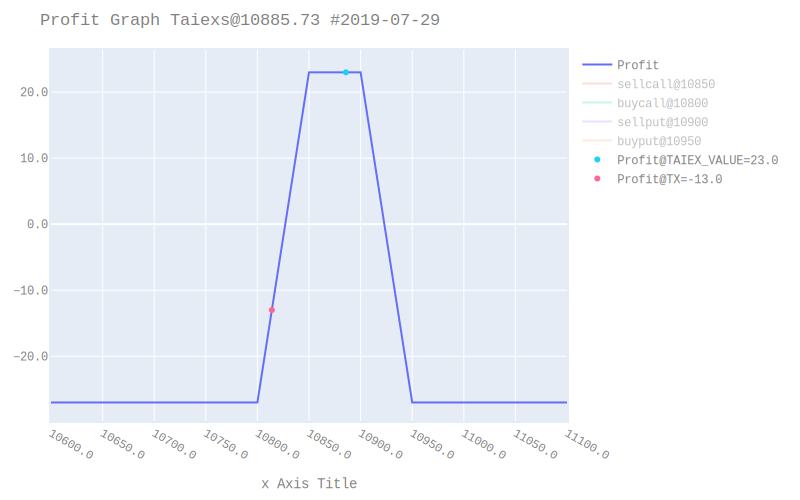

In [26]:
# x = np.arange(TAIEX_VALUE_BOTTOM-300, TAIEX_VALUE_TOP+200, 50)
# y = [0 for _ in range(len(x))]

# totalOtions = []

# sc = options(TAIEX_VALUE_BOTTOM-50, optionsDF, "call", "sell")
# bc = options(sc.strikePrice-50, optionsDF, "call", "buy")
# sp = options(TAIEX_VALUE_TOP+50, optionsDF, "put", "sell")
# bp =options(sp.strikePrice+50, optionsDF, "put", "buy")

# totalOtions.append(sc)
# totalOtions.append(bc)
# totalOtions.append(sp)
# totalOtions.append(bp)

# y = np.sum([op.optionsProfit(x) for op in totalOtions], axis=0)



fig = go.Figure()
fig.add_trace(
    go.Scatter(
            x=x,
            y=y,
            name = f"Profit",
            mode='lines'
))

for op in totalOtions:
    fig.add_trace(op.optionsScatter(x))

fig.add_trace(go.Scatter(
    x=[TAIEX_VALUE],
    y=[profit(TAIEX_VALUE, x, y)],
    mode="markers",
    name = f"Profit@TAIEX_VALUE={profit(TAIEX_VALUE, x, y)}"
    # hovertext=["Text A"]
))
fig.add_trace(go.Scatter(
    x=[dftt.loc[k].iloc[0]['TX/MTX']],
    y=[p],
    mode="markers",
    name = f"Profit@TX={profit(dftt.loc[k].iloc[0]['TX/MTX'], x, y)}"
    # hovertext=["Text A"]
))

fig.update_layout(
    title=f"Profit Graph Taiexs@{TAIEX_VALUE}  #{YEAR}-{MONTH:02}-{DAY:02}",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    width=900,
    height=500,
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=50,
        pad=2
    ),
    xaxis = dict(
        tickmode = 'linear',
        # tick0 = 0.5,
        dtick = 50,
        tickformat='.1f'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.1f'
    )
)
fig.show(renderer="svg", width=800, height=500)

# strategy1

In [27]:
dftt["WinLoss1"] = dftt.apply(lambda x: WinLoss(x, strategy), axis=1)

2018/06/04
2018/06/11
2018/06/25
2018/07/02
2018/07/09
2018/07/16
2018/07/23
[buyput@11050]
2018/07/30
2018/08/06
[buyput@11150]
2018/08/13
sellcall@10650 NOT EXISTS!
Change to sellcall@10600
2018/08/20
2018/08/27
2018/09/03
2018/09/10
2018/09/17
2018/10/01
2018/10/09
2018/10/15
2018/10/22
2018/10/29
2018/11/05
2018/11/12
2018/11/19
2018/11/26
2018/12/03
buyput@10250 NOT EXISTS!
Change to buyput@10300
2018/12/10
2018/12/17
2018/12/24
2019/01/07
2019/01/14
2019/01/21
2019/01/28
2019/02/11
[buycall@9900]
2019/02/18
[buycall@10000]
2019/02/25
[buycall@10250]
2019/03/04
2019/03/11
2019/03/18
2019/03/25
2019/04/01
2019/04/08
2019/04/15
2019/04/22
[buycall@10850]
2019/04/30
[buyput@11100]
2019/05/06
2019/05/13
2019/05/20
2019/05/27
2019/06/03
2019/06/10
2019/06/17
2019/06/24
2019/07/01
[buyput@11000]
2019/07/08
2019/07/15
2019/07/22
2019/07/29
[buyput@11000]
2019/08/05
2019/08/12
[buyput@10600]
2019/08/19
2019/08/26
2019/09/02
2019/09/09
2019/09/16
2019/09/23
[buyput@11050]
2019/10/07
[buyca

In [28]:
dftt["WinLoss1"].describe()

count    101.000000
mean       4.386139
std       30.934760
min      -76.000000
25%        0.000000
50%        0.000000
75%       11.000000
max      136.000000
Name: WinLoss1, dtype: float64

### 收益圖

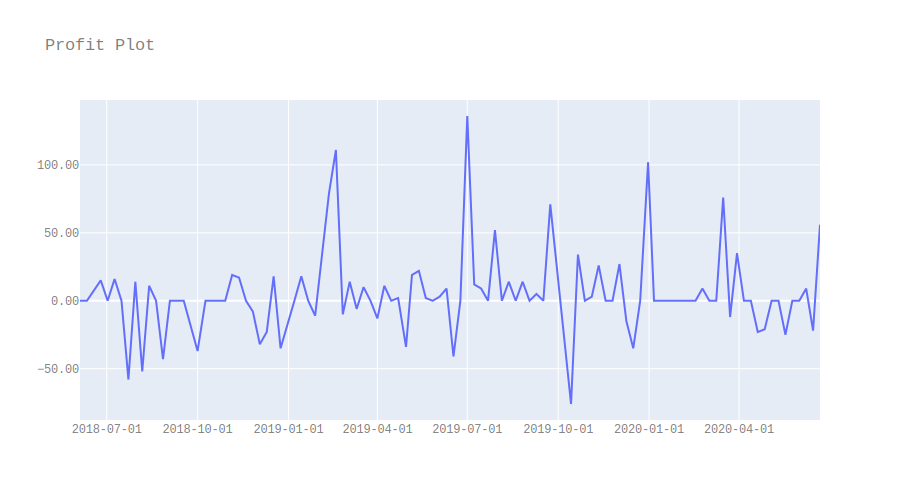

In [29]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=dftt["Date"],
            y=dftt["WinLoss1"],
            name = f"Profit",
            mode='lines'
        ))

fig.update_layout(
    title=f"Profit Plot",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)
fig.show(renderer="svg", width=900, height=500)

# strategy2

In [30]:
dftt["WinLoss2"] = dftt.apply(lambda x: WinLoss(x, strategy2), axis=1)

2018/06/04
2018/06/11
2018/06/25
2018/07/02
2018/07/09
2018/07/16
2018/07/23
2018/07/30
2018/08/06
2018/08/13
buycall@10650 NOT EXISTS!
Change to buycall@10600
2018/08/20
[buycall@10650, buyput@10700]
2018/08/27
2018/09/03
2018/09/10
2018/09/17
2018/10/01
2018/10/09
2018/10/15
[buycall@9900, buyput@9950]
2018/10/22
2018/10/29
[buycall@9500, buyput@9550]
2018/11/05
[buycall@9850, buyput@9900]
2018/11/12
2018/11/19
2018/11/26
2018/12/03
2018/12/10
[buycall@9600, buyput@9650]
2018/12/17
2018/12/24
2019/01/07
2019/01/14
[buycall@9700, buyput@9750]
2019/01/21
2019/01/28
2019/02/11
2019/02/18
2019/02/25
2019/03/04
2019/03/11
2019/03/18
2019/03/25
2019/04/01
2019/04/08
2019/04/15
2019/04/22
2019/04/30
2019/05/06
2019/05/13
2019/05/20
2019/05/27
2019/06/03
2019/06/10
2019/06/17
2019/06/24
2019/07/01
2019/07/08
2019/07/15
2019/07/22
2019/07/29
2019/08/05
2019/08/12
2019/08/19
2019/08/26
2019/09/02
2019/09/09
2019/09/16
2019/09/23
2019/10/07
2019/10/14
2019/10/21
2019/10/28
2019/11/04
2019/11/11

In [31]:
dftt["WinLoss2"].describe()

count    101.000000
mean      -4.168317
std       27.070212
min     -124.000000
25%      -19.500000
50%       -5.000000
75%       18.500000
max       44.000000
Name: WinLoss2, dtype: float64

### 收益圖

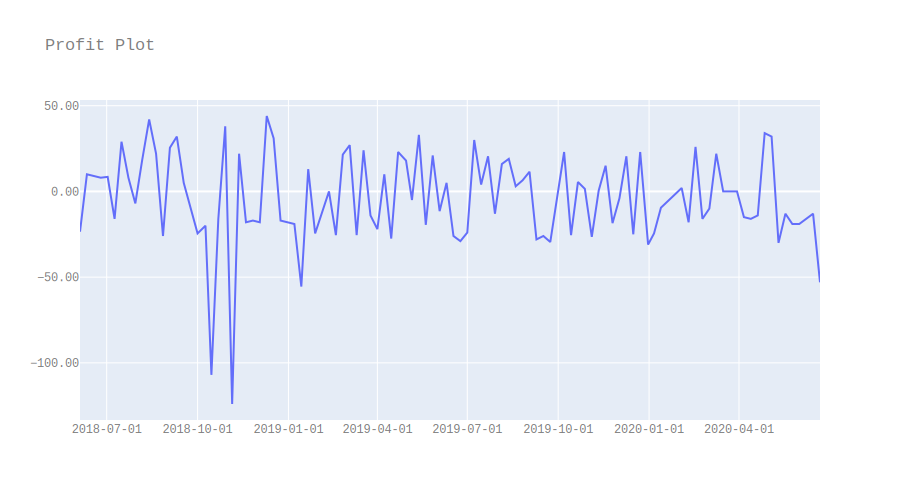

In [32]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=dftt["Date"],
            y=dftt["WinLoss2"],
            name = f"Profit",
            mode='lines'
        ))

fig.update_layout(
    title=f"Profit Plot",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)
fig.show(renderer="svg", width=900, height=500)

# strategy3

In [33]:
dftt["WinLoss3"] = dftt.apply(lambda x: WinLoss(x, strategy3), axis=1)

2018/06/04
[buyput@11200]
2018/06/11
[buyput@11200]
2018/06/25
[buycall@10700]
2018/07/02
[buycall@10700]
2018/07/09
[buyput@10800]
2018/07/16
[buycall@10750]
2018/07/23
[buyput@11000]
2018/07/30
[buycall@10950]
2018/08/06
2018/08/13
buycall@10650 NOT EXISTS!
Change to buycall@10600
[buycall@10600]
2018/08/20
[buycall@10600]
2018/08/27
[buycall@10850]
2018/09/03
[buycall@10900]
2018/09/10
2018/09/17
[buycall@10750]
2018/10/01
[buyput@11150]
2018/10/09
2018/10/15
[buycall@9850]
2018/10/22
[buycall@9900]
2018/10/29
[buycall@9450]
2018/11/05
[buyput@9950]
2018/11/12
2018/11/19
2018/11/26
[buycall@9700]
2018/12/03
[buycall@10050]
2018/12/10
[buycall@9550]
2018/12/17
[buyput@9850]
2018/12/24
2019/01/07
[buycall@9500]
2019/01/14
2019/01/21
[buyput@9950]
2019/01/28
[buycall@9950]
2019/02/11
[buyput@10100]
2019/02/18
2019/02/25
[buyput@10450]
2019/03/04
[buycall@10250]
2019/03/11
[buyput@10350]
2019/03/18
[buycall@10450]
2019/03/25
[buycall@10400]
2019/04/01
2019/04/08
[buycall@10750]
2019/04/

In [34]:
dftt["WinLoss3"].describe()

count    101.000000
mean      -4.004950
std       79.203867
min     -202.000000
25%      -62.000000
50%       -5.000000
75%       40.000000
max      187.000000
Name: WinLoss3, dtype: float64

### 收益圖

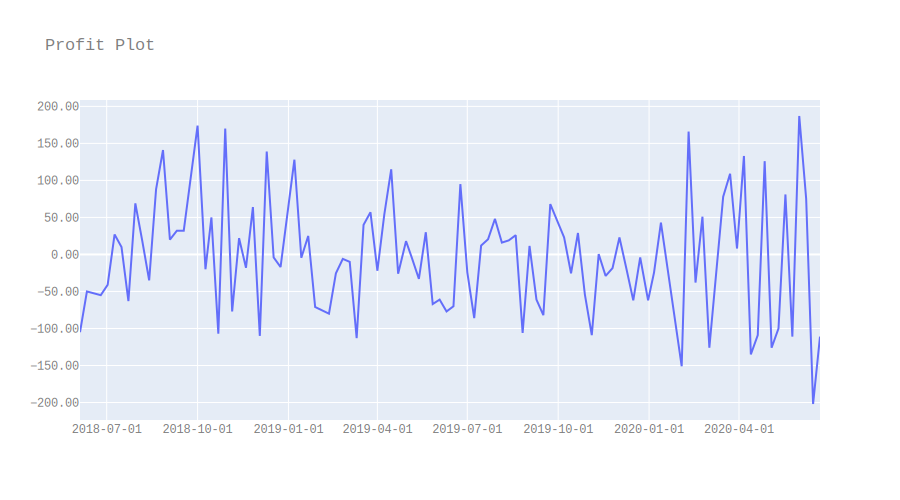

In [35]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=dftt["Date"],
            y=dftt["WinLoss3"],
            name = f"Profit",
            mode='lines'
        ))

fig.update_layout(
    title=f"Profit Plot",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)
fig.show(renderer="svg", width=900, height=500)

# strategy4

In [36]:
dftt["WinLoss4"] = dftt.apply(lambda x: WinLoss(x, strategy4), axis=1)

2018/06/04
[buycall@11100, buyput@11150]
2018/06/11
[buycall@11100, buyput@11150]
2018/06/25
[buycall@10750, buyput@10800]
2018/07/02
[buycall@10750, buyput@10800]
2018/07/09
[buycall@10700, buyput@10750]
2018/07/16
[buycall@10800, buyput@10850]
2018/07/23
[buycall@10900, buyput@10950]
2018/07/30
[buycall@11000, buyput@11050]
2018/08/06
[buycall@11000, buyput@11050]
2018/08/13
buycall@10650 NOT EXISTS!
Change to buycall@10600
[buycall@10700, buyput@10750]
2018/08/20
[buycall@10650, buyput@10700]
2018/08/27
[buycall@10900, buyput@10950]
2018/09/03
[buycall@10950, buyput@11000]
2018/09/10
[buycall@10700, buyput@10750]
2018/09/17
[buycall@10800, buyput@10850]
2018/10/01
[buycall@11050, buyput@11100]
2018/10/09
[buycall@10450, buyput@10500]
2018/10/15
[buycall@9900, buyput@9950]
2018/10/22
[buycall@9950, buyput@10000]
2018/10/29
[buycall@9500, buyput@9550]
2018/11/05
[buycall@9850, buyput@9900]
2018/11/12
[buycall@9800, buyput@9850]
2018/11/19
[buycall@9800, buyput@9850]
2018/11/26
[buycal

In [37]:
dftt["WinLoss4"].describe()

count    101.000000
mean     -14.009901
std       59.131759
min     -168.000000
25%      -52.000000
50%      -28.000000
75%       14.000000
max      184.000000
Name: WinLoss4, dtype: float64

### 收益圖

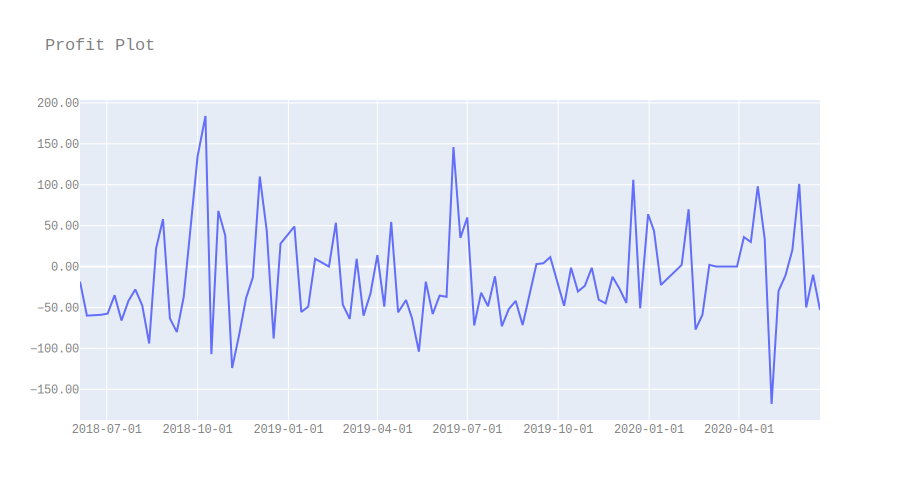

In [38]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=dftt["Date"],
            y=dftt["WinLoss4"],
            name = f"Profit",
            mode='lines'
        ))

fig.update_layout(
    title=f"Profit Plot",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)
fig.show(renderer="svg", width=900, height=500)